# Cómo descubrir una nueva partícula

En este ejercicio se introduce el detector CMS (Solenoide compacto de muones: Compact Muon Solenoid) y el concepto de pseudo-rapidez. With the real data collected by CMS detector the effect of the pseudorapidity to the resolution of the CMS detector is observed.

### Pseudo-rapidez

In física de partículas experimental $\eta$ es una coordenada espacial utilizada para describir el ángulo entre la partícula y el haz de partículas. La pseudo-rapidez está determinada por la ecuación:

$$ \eta \equiv -\ln(\tan(\frac{\theta}{2})), $$

Donde $\theta$ es el ángulo de la partícula relativo al haz de partículas.

La pseudo-rapidez describe entonces el ángulo entre una partícula detectada y el haz de partículas. En la imagen abajo el haz de partículas viaja horizontalmente de izquierda a derecha. Entonces con valores grandes de $\eta$ una partícula creada en la colisión diferiría sólo un poco de la dirección del haz. Con valores pequeños de $\eta$ la desviación es mayor.

<img src="../Imagenes/Pseudorapidity_plot.svg" alt="Image of pseudorapidity values" style="height: 200px">

(Image: Wikimedia user Mets501, https://en.wikipedia.org/wiki/Pseudorapidity#/media/File:Pseudorapidity_plot.svg)
<br>
<br>
<br>

### El efecto de la pseudo-rapidez en la resolución de la medida

Con el detector CMS por ejemplo el momento lineal de las partículas puede ser medido. La pseudo-rapidez $\eta$ afecta la resolución de la medición del momento lineal. Las partículas que chocan en la parte de en medio del detector (en el barril) pueden ser medidas con más precisión que las partículas que chocan en el final del detector (endcap). 

La razón de esto es que probablemente las partículas que se han dirigido hacia el final del detector han encontrada más materia (más partículas) que las partículas que chocan en el barril. La interacción de otra materia causará imprecisión en la medición de partículas al final del detector.

En la imagen abajo hay un bosquejo de dos partículas creadas en el evento de colisión. Una choca en la mitad del detector y otra al final del detector. También se muestran los valores de la pseudo-rapidez $\eta$ y los ángulos $\theta$ de las partículas.

<img src="../Imagenes/Sylinteri.svg" alt="Draft of the CMS detector" style="height: 600px">

### ¡Empecemos!

Empezaremos observando como el efecto de la pseudo-rapidez sobre la resolución de la medida puede ser observado con datos reales recolectados por el detector CMS. 

Utilizaremos los datos recolectados en 2011 [1]. De la base de datos primaria 10851 eventos de colisión donde han habido exactamente dos muones han sido seleccionados en el archivo "Zmumu_Run2011A_masses.csv". (La selección se ha realizado con un código que esta disponible libremente en https://github.com/tpmccauley/dimuon-filter.) Las mediciones del momento lineal y la energía de los muones están escritos en el archivo. 

De los valores medidos del momento lineal y las energías, la masa invariante para los muones para cada eventos es calculada. La masa invariante es un concepto matemático, no una masa física. La masa invariante está determinada por la ecuación:

$$ M = \sqrt{(E_1 + E_2)^2-(\vec{p_1} + \vec{p_2})^2}. $$

En la ecuación $E_1$ y $E_2$ son las energías de los muones y $\vec{p_1}$ y $\vec{p_2}$ el momento lineal de los muones. 

Si el par de muones viene del decaimiento de un bosón Z, la masa invariante calculada para ese par de muones equivale a la masa física del bosón Z (91.1876 GeV, [Particle Data Group](http://pdg.lbl.gov/2012/listings/rpp2012-list-z-boson.pdf)). Si los dos muones se originan de algún otro proceso (hay muchos procesos diferentes en las colisiones de partículas) entonces la masa invariante calculada es algo distinto.

Observemos la masa invariante calculada de diferentes eventos realizando un histograma de ellos. El histograma muestra en cuantos eventos el valor de la masa invariante está en un cierto rango de valores. Con el histograma uno puede ver qué tan cerca de la masa del bosón Z (91.1876 GeV) las diferentes masas invariantes van a ser.  
<br>
<br>
<br>
[1]  CMS collaboration (2016). DoubleMu primary dataset in AOD format from RunA of 2011 (/DoubleMu/Run2011A-12Oct2013-v1/AOD). CERN Open Data Portal. DOI: [10.7483/OPENDATA.CMS.RZ34.QR6N](http://doi.org/10.7483/OPENDATA.CMS.RZ34.QR6N).

### 1) Seleccionando los eventos

<img src="../Imagenes/Pseudorapidity_plot.svg" alt="Image of pseudorapidity values" style="height: 200px">

Primero seleccionaremos de todos los eventos dos grupos de eventos en los que la pseudo-rapidez de los dos muones ha sido relativamente larga (e.g. $\eta$ > 1.52) y relativamente corta (e.g. $\eta$ < 0.45). La selección se realiza con el código abajo. Queremos alrededor de la misma cantidad de eventos en ambos grupos para que pueda realizarse la comparación.

Realice la selección ejecutando el código abajo. Puede ejecutar el código haciendo clic en la casilla de código y luego presionando _Ctrl_ + _Enter_. La línea separada por # en el código son comentarios que no afectarán al programa. 

In [7]:
# Importar todos los módulos necesarios. Pandas es para análisis de datos, numpy es para cálculos científicos
# y matplotlib.pyplot es para hacer gráficas. Los módulos son llamados pd, np y plt.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def mll(dataset):
    return np.sqrt(2*dataset.pt1*dataset.pt2*(np.cosh(dataset.eta1-dataset.eta2) - np.cos(dataset.phi1-dataset.phi2)))

# Crear una nueva estructura de marco de datos desde el archivo "Zmumu_Run2011A_masses.csv"
dataset_mm = pd.read_csv('../Datos/DoubleMuRun2011A.csv')

In [124]:
from scipy.optimize import curve_fit

def expo(x, *params):
    """ An exponential curve. *NB* The constant is in the exponent! 
    params: const, slope """
    const, slope = params
    return np.exp(const + slope*x)

def gaus(x, *params):
    # An un-normalized Gaussian curve.
    # params: N, mu, sigma """abs
    N, mu, sigma = params
    return N*np.exp(-0.5 * ((x-mu)/sigma)**2 )

def gaus_exp(x, *params):
    # An un-normalized Gaussian curve.
    # params: N, mu, sigma """abs
    N, mu, sigma, const, slope = params
    return N*(np.exp(-0.5 * ((x-mu)/sigma)**2 )) +  np.exp(const + slope*x) 

def crystal_ball(x, *params):
    """ A Gaussian curve on one side and a power-law on the other side. Used in
    physics to model lossy processes.
    See http://en.wikipedia.org/wiki/Crystal_Ball_function
  Note that the definition used here differs slightly. At the time of this
  writing, the wiki article has some discrepancies in definitions/plots. This
  definition makes it easier to fit the function by using complex numbers
  and by negating any negative values for a and n.
  This version of the crystal ball is normalized by an additional parameter.
  params: N, a, n, xb, sig
  """
    x = x+0j # Prevent warnings...
    N, a, n, xb, sig = params
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    try:
        return total.real
    except:
        return total
    return total


def crystal_ball_exp(x, *params):
    """ A Gaussian curve on one side and a power-law on the other side. Used in
    physics to model lossy processes.
    See http://en.wikipedia.org/wiki/Crystal_Ball_function
  Note that the definition used here differs slightly. At the time of this
  writing, the wiki article has some discrepancies in definitions/plots. This
  definition makes it easier to fit the function by using complex numbers
  and by negating any negative values for a and n.
  This version of the crystal ball is normalized by an additional parameter.
  params: N, a, n, xb, sig
  """
    x = x+0j # Prevent warnings...
    N, a, n, xb, sig, const, slope = params
    if a < 0:
        a = -a
    if n < 0:
        n = -n
    aa = abs(a)
    A = (n/aa)**n * np.exp(- aa**2 / 2)
    B = n/aa - aa
    total = 0.*x
    total += ((x-xb)/sig  > -a) * N * np.exp(- (x-xb)**2/(2.*sig**2))
    total += ((x-xb)/sig <= -a) * N * A * (B - (x-xb)/sig)**(-n)
    total += N*np.exp(const + slope*x) 
    try:
        return total.real
    except:
        return total
    return total

    
def cruijff(x, *params):
    n, mu, sig, alphaL, alphaR = params
    x = x+0j # Prevent warnings...
    dx = x-mu
    
    f =  2*sig*sig
    f += (dx<0)*alphaL*dx*dx
    f += (dx>0)*alphaR*dx*dx
    sol = n * (np.exp(-dx*dx/f))
    try: 
        return sol.real
    except:
        return sol
    return sol 




def centers_from_borders(borders):
    return borders[:-1] + np.diff(borders) / 2

# Plot the histogram and the fitted function.
xspace=np.linspace(60,120,1000)

### 2) Creando histogramas

A continuación crearemos histogramas separados de la masa invariante para los eventos con pseudo-rapidez grande y para los eventos con pseudo-rapidez pequeña. Con los histogramas podemos comparar las dos situaciones. 

### Histograma de masa invariante

Empecemos con los eventos donde la pseudo-rapidez de ambos muones ha sido grande. Ejecute el código haciendo clic en la casilla del código y luego presionando _Ctrl_ + _Enter_.

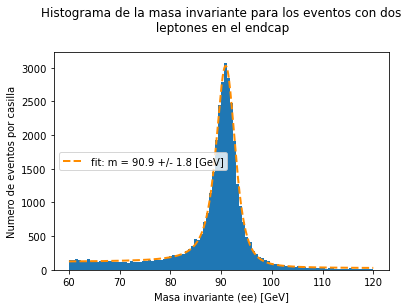

In [11]:
# Guardar la masa invariante a la variable "inv_mass1".
#mll_mm = mll(dataset_mm)

# Jupyter Notebook utiliza "funciones mágicas". Con esta función es posible graficar
# el histograma directamente en el cuaderno. 
%matplotlib inline

# Crear el histograma desde los datos en la variable "inv_mass1". Establecer el rango y número de casillas. 
n_mm, bins_mm, _ = plt.hist(dataset_mm.M, bins=100, range=[60,120])
x_mm = centers_from_borders(bins_mm)


par_g, par_cov_g = curve_fit(gaus, x_mm, n_mm, p0 = [1, 90, 1.]) 
par_cr, par_cov_cr = curve_fit(cruijff, x_mm, n_mm, p0 = [par_g[0], par_g[1], par_g[2],0.19,0.01], 
                               bounds=((0,par_g[1]-0.5*par_g[2],0,0,0),(1.1*par_g[0],par_g[1]+0.5*par_g[2],1.2*par_g[2],2,2)),
                               method='trf')

plt.plot(xspace, cruijff(xspace,*par_cr ), '--', color='darkorange', linewidth=2, label='fit: m = %3.1f +/- %3.1f [GeV]' %(par_cr[1],par_cr[2])) 

# Establecer el eje y en el rango de 0 a 60.
#axes = plt.gca()
#axes.set_ylim([0,2500])

# Nombrar los ejes y darles un título.
plt.xlabel('Masa invariante (ee) [GeV]')
plt.ylabel('Numero de eventos por casilla')
plt.title('Histograma de la masa invariante para los eventos con dos\n leptones en el endcap\n')
plt.legend()
plt.show()


### Compare data to fit

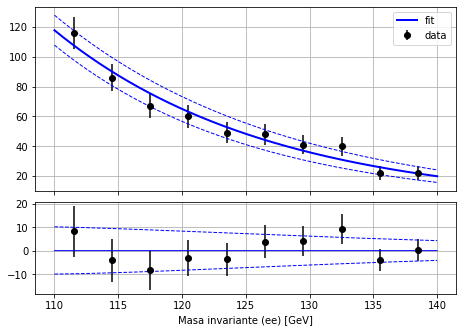

In [165]:
m_H = np.random.normal(125.10,1.,200)
m_ll = dataset_mm.M

counts,bin_edges = np.histogram(m_ll,10,range=[110,140])
bin_centres = centers_from_borders(bin_edges)
err = np.sqrt(counts)

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=-1.0)

axs[0].errorbar(bin_centres, counts, yerr=err, fmt='o', color='black', label='data')

par_exp, par_cov_exp = curve_fit(expo, bin_centres, counts, p0 = [1., 1.]) 
par_exp_1sigup, par_cov_exp = curve_fit(expo, bin_centres, counts+err, p0 = [1., 1.]) 
par_exp_1sigdn, par_cov_exp = curve_fit(expo, bin_centres, counts-err, p0 = [1., 1.]) 

xspace=np.linspace(110,140,10000)
axs[0].plot(xspace, expo(xspace,*par_exp ), '-', color='blue', linewidth=2, label='fit') 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigup ), '--', color='blue', linewidth=1) 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigdn ), '--', color='blue', linewidth=1) 

ratio     = counts-expo(bin_centres,*par_exp)
ratio_err = err

axs[1].errorbar(bin_centres, ratio, yerr=ratio_err, fmt='o', color='black', label='data')
axs[1].plot(xspace, np.zeros_like(xspace), '-', color='blue', linewidth=1, label='fit') 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigup )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1, label='fit') 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigdn )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1, label='fit') 
axs[0].axes.set_xticklabels([])

# Nombrar los ejes y darles un título. 
plt.xlabel('Masa invariante (ee) [GeV]')
axs[0].legend()
axs[1].grid()
axs[0].grid()
plt.show()

### Injecting signal

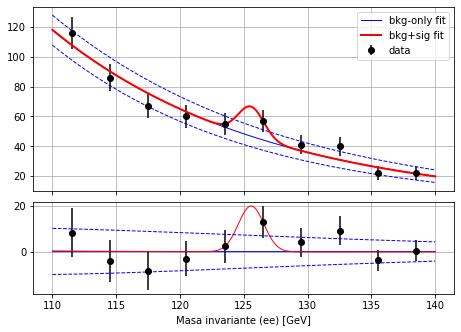

Total number of ``observed signal'' events: 16


In [169]:
from scipy.integrate import quad

N_signal = 15

m_H = np.random.normal(125.10,1.,200)
m_ll = dataset_mm.M

mH_counts,edges = np.histogram(m_H[0:N_signal],10,range=[110,140])
sig_bkg=counts+mH_counts
mH_err = np.sqrt(sig_bkg)

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=-1.0)

axs[0].errorbar(bin_centres, sig_bkg, yerr=mH_err, fmt='o', color='black', label='data')

par_ge, _ = curve_fit(gaus_exp, bin_centres, sig_bkg, p0 = [30.,125.,2., par_exp[0], par_exp[1]],
                      bounds=((20,110.,0.,0.9999999*par_exp[0],1.11111111*par_exp[1]),(40,140.,5.,1.1111111*par_exp[0],0.9999999*par_exp[1])),
                      method='trf') 


xspace=np.linspace(110,140,10000)
axs[0].plot(xspace, expo(xspace,*par_exp ), '-', color='blue', linewidth=1, label='bkg-only fit') 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigup ), '--', color='blue', linewidth=1) 
axs[0].plot(xspace, expo(xspace, *par_exp_1sigdn ), '--', color='blue', linewidth=1) 
axs[0].plot(xspace, gaus_exp(xspace,*par_ge ), '-', color='red', linewidth=2, label='bkg+sig fit') 

ratio     = sig_bkg-expo(bin_centres,*par_exp)
ratio_err = err

axs[1].errorbar(bin_centres, ratio, yerr=ratio_err, fmt='o', color='black')
axs[1].plot(xspace, np.zeros_like(xspace), '-', color='blue', linewidth=1) 
axs[1].plot(xspace, gaus_exp(xspace,*par_ge )-expo(xspace,*par_exp ), '-', color='red', linewidth=1) 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigup )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1) 
axs[1].plot(xspace, expo(xspace, *par_exp_1sigdn )-expo(xspace,*par_exp ), '--', color='blue', linewidth=1) 

axs[0].axes.set_xticklabels([])

# Nombrar los ejes y darles un título. 
plt.xlabel('Masa invariante (ee) [GeV]')
axs[0].legend()
axs[1].grid()
axs[0].grid()
plt.show()

F_bkg = quad(expo, 110., 140., args=(par_exp[0],par_exp[1]))
F_sig = quad(gaus_exp, 110., 140., args=(par_ge[0],par_ge[1],par_ge[2],par_ge[3],par_ge[4]))

N_sig = (F_sig[0]-F_bkg[0])/((140-110)/len(bin_centres))
                             
print("Total number of ``observed signal'' events: %d" %(N_sig))

### 3) Ejercicio

__Calcula el p-valor en función del número de sucesos de señal inyectada__
__Calcula el p-valor en función del número de sucesos de señal inyectada__

Ttest_relResult(statistic=1.4638501094227998, pvalue=0.17726770250560825)